# wordcloud 함수 (2번째 라인까지가 함수, 이후 라인은 확인용. 순서대로 실행!)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [36]:
def wordcloud(plaintext, filename, wc_backgroundcolor='black', wc_colormap='autumn'):
    """
    ------------------------------------------------------------------------------
    
    텍스트를 받아 전처리함수를 통해 토큰화 한 후 빈도를 기반으로 wordcloud 그림파일을 생성합니다. 
    키값으로 토큰, 밸류값으로 빈도 수를 갖는 딕셔너리를 반환합니다.
    
    ------------------------------------------------------------------------------
    
    파라미터 설명
    
    plaintext : txt, 인스타그램 포스트들이 수집된 원문 텍스트. 'HOTKEY123!@#'로 포스트들을 구분한다.
    filename : str, wordcloud 그림파일을 저장할 파일이름.
    wc_backgroundcolor : str, wordcloud 그림파일의 배경색, 기본값은 'black'.
    wc_colormap : str, wordcloud 그림파일의 컬러맵(wordcloud 모듈에 저장된), 기본값은 'autumn'.
    
    ------------------------------------------------------------------------------
    """

# 입력받은 원문을 전처리함수를 통해 토큰화
    pt = preprocess(plaintext=plaintext, sep='HOTKEY123!@#', targetMorphs=['NNP', 'NNG'])

# 토큰들의 빈도를 dict형태로 저장
    voca = dict()
    for post in pt:
        for term in post:
            if term in voca:
                voca[term] += 1
            else:
                voca[term] = 1
                
# 빈도 순(밸류값)으로 정렬                
    voca_sorted = sorted(voca.items(), key=lambda x: x[1], reverse=True)

# 한글로 wordcloud 이미지를 생성하기 위해 글꼴 불러오기
    font_path ='malgun.ttf'
    
# 이미지 파일 읽어오기
    im = Image.open('mask_camera.png') 
    
# 이미지 파일 전처리
    mask=Image.new("RGB",im.size, (255,255,255))
    mask.paste(im)
    mask=np.array(mask)
    
# wordcloud 이미지 생성
    wc=WordCloud(background_color='black', colormap=wc_colormap,font_path = font_path, mask = mask)
    wc=wc.generate_from_frequencies(voca)
    
# 입력받은 경로에 저장, 파일이름 중복될 경우 덮어쓰여짐
    wc.to_file(filename=f'{filename}')
    
    return voca_sorted

# 전처리 함수

In [27]:
from kiwipiepy import Kiwi
from math import log1p
import numpy as np
import konlpy
import nltk
import re

def preprocess(plaintext, sep,
               morphemeAnalyzer='kiwi', targetMorphs=['NNP','NNG'],removehashtag=True, returnMorph=False,
               returnEnglishMorph=False, eeTagRule={'NNP':'NNP'},
               filterMorphemeAnalyzer='kiwi',filterTargetMorphs=['NNP','NNG','W_HASHTAG'],
               k_1Filter=1.5 ,bFilter=0.75,
               filterThreshold = 3.315):
    
    # 형태소 분석기를 텍스트로 정의 시 해당 형태소 분석기를 할당
    tma = set_morpheme_analyzer(morphemeAnalyzer)
    fma = set_morpheme_analyzer(filterMorphemeAnalyzer)
    
    # 서버에서 "글1 구분자 글2 구분자" 형식의 데이터를 받는다고 가정
    data = plaintext.split(sep)
    # 구분자로 데이터를 받으면 글이 존재하지 않는 마지막 부분을 삭제
    
    if data[-1] in ('',' ','\n',[],['\n'],[' ']):
        data=data[:-1]
    
    if removehashtag == True:
        if '#' in sep:
            sep = sep.replace('#','')
        tdata = plaintext.replace('#',' ').split(sep)
        if tdata[-1] in ('',' ','\n',[],['\n'],[' ']):
            tdata=tdata[:-1]
    else:
        tdata = data*1
            
    postLens = list()
    for post in data:
        postLens.append(len(post))

    flag = (morphemeAnalyzer==filterMorphemeAnalyzer, set(targetMorphs)==set(filterTargetMorphs))
    
    
    ftok = data_tokenize(data,fma,filterTargetMorphs,
                         returnMorph=False,
                         returnEnglishMorph=True,
                         eeTagRule={'W_HASHTAG':'W_HASHTAG'})
    ttok = data_tokenize(tdata,tma,targetMorphs,
                         returnMorph=returnMorph,
                         returnEnglishMorph=returnEnglishMorph, eeTagRule=eeTagRule)
    
    filterScores = BM25(ftok, postLens, k_1=k_1Filter, b=bFilter)
    
    spamCount=0
    for idx in range(len(filterScores)):
        if filterScores[idx] < filterThreshold:
            spamCount+=1
            ttok.pop(idx-spamCount)
    print("%s 개의 데이터가 삭제되었습니다."%spamCount)
    
    return ttok

def set_morpheme_analyzer(maText):
    if maText in ['kiwi','Kiwi','KIWI','키위']:
        return Kiwi()
    elif maText in ['Hannanum', 'hannanum', 'HANNANUM','한나눔']:
        return konlpy.tag.Hannanum()
    elif maText in ['Komoran','KOMORAN','komoran','코모란']:
        return konlpy.tag.Komoran()
    elif maText in ['Kkma','KKMA','kkma','꼬꼬마']:
        return konlpy.tag.Kkma()
    elif maText in ['Okt','OKT','okt','오픈코리안텍스트','트위터']:
        return konlpy.tag.Okt()
    elif maText in ['Mecab','mecab','MECAB','미캐브']:
        return konlpy.tag.Mecab()
    else:
        raise Exception('No such morpheme analyzer\nSupported morpheme analyzers are Kiwi, KoNLPy(Hannanum, Komoran, Kkma, Okt, Mecab)')
        
def data_tokenize(data,morphemeAnalyzer,targetMorph,
                  returnMorph=False,
                  returnEnglishMorph=False,
                  eeTagRule={'NNP':'NNP'}):
    
    returnData = list()
    
    maDir = dir(morphemeAnalyzer)
    if 'pos' in maDir:
        for post in data:
            selected = list()
            if returnEnglishMorph==True:
                eeTags, post = emoji_english_preprocess(post, tagRule=eeTagRule, returnMorph=returnMorph)
                selected += eeTags
            
            for tok in morphemeAnalyzer.pos(post):
                if tok[1] in targetMorph:
                    if returnMorph==True:
                        selected.append((tok[0],tok[1]))
                    else:
                        selected.append(tok[0])
            returnData.append(selected)
    
    elif 'tokenize' in maDir:
        for post in data:
            selected = list()
            if returnEnglishMorph==True:
                eeTags, post = emoji_english_preprocess(post, tagRule=eeTagRule, returnMorph=returnMorph)
                selected += eeTags
            
            for tok in morphemeAnalyzer.tokenize(post):
                if tok.tag in targetMorph:
                    if returnMorph==True:
                        selected.append((tok.form,tok.tag))
                    else:
                        selected.append(tok.form)
            returnData.append(selected)
    else:
        raise Exception('Not supported morpheme analyzer instance')
    return returnData

def BM25(data, postLens, k_1=1.5, b=0.75):
    avgPostLen = np.mean(postLens)
    
    N = len(data)
    
    n = dict()
    for post in data:
        uniqueToks = set(post)
        for tok in uniqueToks:
            try:
                n[tok]+=1
            except:
                n[tok] = 1
    
    IDF = dict()
    for tok in n.keys():
        IDF[tok] = log1p((N-n[tok]+0.5)/(n[tok]+0.5))


    filterScores = list()

    for postidx, post in enumerate(data):
        postScore = 0
        for tok in post:
            tokCount = post.count(tok)
            postScore += (IDF[tok] * (
                (tokCount*(k_1+1))/(
                    tokCount+(k_1*(1-b+(b*(postLens[postidx]/avgPostLen)))))))
        try:
            filterScores.append((postScore/len(post)))
        except:
            filterScores.append(0)

    return filterScores

def emoji_english_preprocess(post, tagRule={'NNP':'NNP'}, returnMorph=True):
    returnData = list()
    
    emojis = re.findall(':[_A-Za-z]+:',post)
    for emoji in set(emojis):
        emojiCounts = post.count(emoji)
        post = post.replace(emoji,'')
        returnData+=([(emoji,'EMJ')]*emojiCounts)
        
    hashTags = re.findall('#[_A-Za-z]',post)
    for hashTag in set(hashTags):
        hTagCounts = post.count(hashTag)
        post = post.replace(hashTag,'')
        returnData+=([(hashTag,'W_HASHTAG')]*hTagCounts)

    
    engChunks = re.findall('[A-Za-z]+[\' ]?[A-Za-z]+',post)
    for engChunk in set(engChunks):
        chunkCounts = post.count(engChunk)
        post = post.replace(engChunk,'')

        targetToken = list()
        for token in nltk.pos_tag(nltk.word_tokenize(engChunk)):
            if token[1] in tagRule: 
                targetToken.append((token[0],token[1]))
        returnData+=(targetToken*chunkCounts)

    filterData = list()
    for token in returnData:
        if token[1] in tagRule:
            if returnMorph==True:
                filterData.append((token[0],tagRule[token[1]]))
            else:
                filterData.append(token[0])
        
    return filterData, post


In [71]:
with open('월드컵_1203.txt', 'r',encoding='utf-8') as f:
    plaintext = f.read()

In [40]:
a = wordcloud(plaintext, 'test.png')

119 개의 데이터가 삭제되었습니다.


In [74]:
ptlist = []
for post in pt:
    ptlist.extend(post)

In [72]:
pt = preprocess(plaintext=plaintext, sep='HOTKEY123!@#', targetMorphs=['NNP', 'NNG'])

119 개의 데이터가 삭제되었습니다.


In [77]:
' '.join(ptlist)

'생일 전전 전야제 축구 밖 오늘 밖 인형 뽑기 방 와중 축구공 쿼카 뜻 말 자랑 대한민국 강 가즈아 스타 업뎃 셀카 기록 남 기기 월드컵 강 진출 생일 전전 전야제 생일 주간 시작 시작 자랑 대한민국 축구 일상 확률 미쳤슴댜 브라질 리언 가즈아 카타르 월드컵 월드컵 대한민국 강 진출 눈물 최고 선수 월드컵 강가즈아 축구 월드컵 응원 대한민국 만세 응원 뜀박질 안내 요원 손 난로 주심 안양 호날두 월드컵 브라질 꺽자 월드컵 대한민국 브라질 꺽고 강 고고 씽 꺄 선수 진출 확정 모습 눈물 손흥민 발 고생 월드컵 월드컵 응원 강 진출 확정 축구 카타르 월드컵 대한민국 포르투갈 한국 승리 조 강 진출 한국 죽지 않았슴다 감동 순간 하나님 선수 고생 진출 감사 얼마 강 월드컵 대한민국 포르투갈 난리 월드컵 벤 투호 손흥민 황희찬 골 김영권 골 포르투갈전 슬라이딩 재현 대한민국 강 진출 두바이 밥 히밥 두비이 두바이 미디어 시티 월드컵 대한민국 강 진출 히밥 헷 기분 밤 멈머 댕나잇 대한민국 강 진출 대한민국 광화문광장 월드컵 황희찬 강 개 황 꼭지 월드컵 대한민국 대한민국 강 축하 축구 정도 스포츠 마케터 싱가포르 출장 도착 대한민국 강 진출 출장 시작 월드컵 대한민국 축구 국가 대표 팀 진출 기내 축구 관람 스포츠 마케터 자랑 대표 팀 월드컵 대표 팀 축구 강 한국 반 투쟁 노력 자랑 브라질 꺽자 월드컵 대한민국 브라질 꺽고 강 고고 씽 토 대한민국 강 진출 기적 새벽 승리 대한 아들 고생 대한민국 n그대 밤 카타르 월드컵 대한민국 강 진출 대한민국 기적 포토 일기 축구 월드컵 대한민국 만세 인생 오늘 손흥민 행복 밤 승리 강 진출 현장 추가 시간 골 사람 카타르 생활 한국 포르투갈 포르쿠갈 한국 카타르 월드컵 월드컵 강 진출 월드컵 강 월드컵 응원 축구 포르투갈 대한민국 우리나라 강 자랑 대한민국 강 나라 진출 나라 오늘 기억 우리 진영 골 단독 포르투갈 수비 수비 침착 완벽 패스 손흥민 침착 황희찬 후반 우루과이 가나 월드컵 헤딩 손흥민 대힌 민국 축구 대표 딘

# 시각화 연습

119 개의 데이터가 삭제되었습니다.


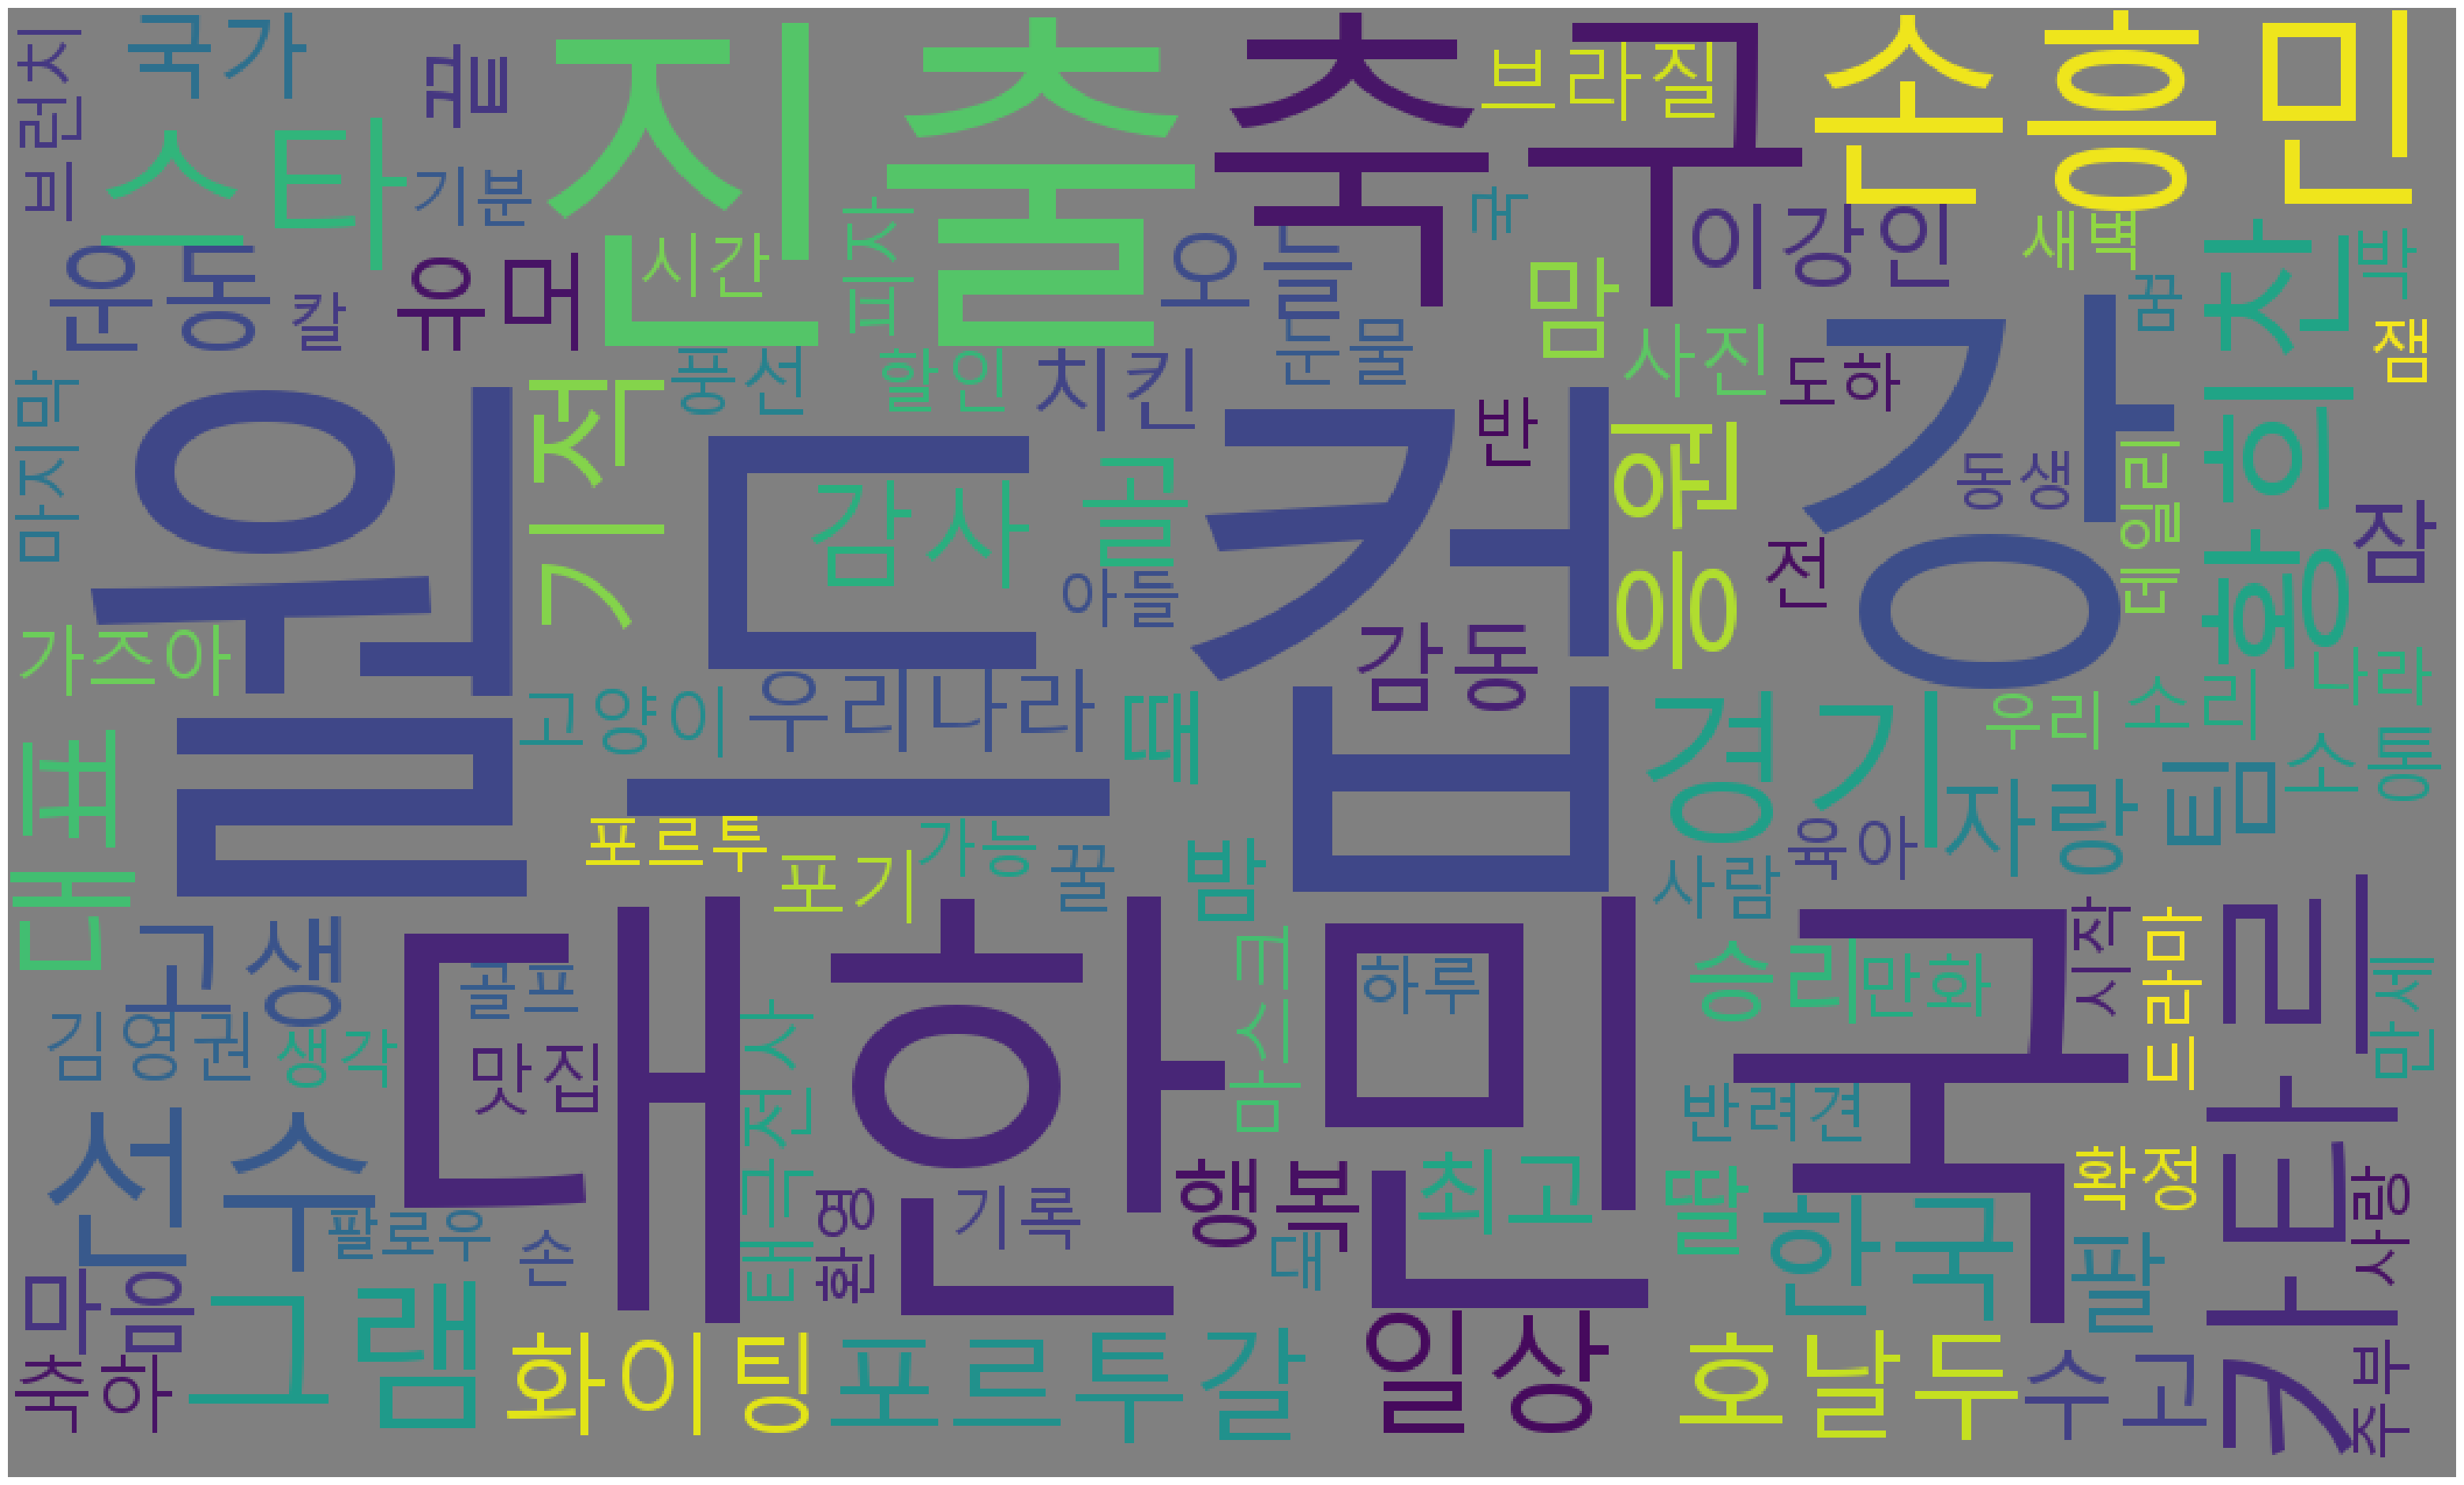

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import re
import wikipedia
import nltk
from nltk.corpus import stopwords
%matplotlib inline

# # wiki = wikipedia.page('Climatechange')
# # text = wiki.content
# # Clean text
# text_c = re.sub('[^A-Za-z0-9°]+', ' ', text)
# text_c = text_c.replace('\n', '').lower()
# type(text_c)
font_path ='malgun.ttf'

pt = preprocess(plaintext=plaintext, sep='HOTKEY123!@#', targetMorphs=['NNP', 'NNG'])
ptlist = []
for post in pt:
    ptlist.extend(post)
text_c = ' '.join(ptlist)

from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width= 1000, height = 600, max_words=100,
                      random_state=1, background_color='gray', colormap='viridis_r',
                      collocations=False, stopwords = STOPWORDS, font_path=font_path).generate(text_c)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

In [80]:
stop_words = set(stopwords.words("english"))

#create function to get a DataFrame
def get_df(input_text):
    list_words = input_text.split(' ')
    set_words_full = list(set(list_words))
    
    #remove stop words
    set_words = [i for i in set_words_full if i not in stop_words]
    
    #count each word
    count_words = [list_words.count(i) for i in set_words]
    
    #create DataFrame
    df = pd.DataFrame(zip(set_words, count_words), columns=['words','count'])
    df.sort_values('count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#create function to get a color dictionary
def get_colordict(palette,number,start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

df_words = get_df(text_c)
df_words.head(10)

,words,count
0,월드컵,217
1,대한민국,140
2,강,123
3,진출,94
4,축구,73
5,손흥민,60
6,카타르,55
7,선수,41
8,경기,36
9,스타,34


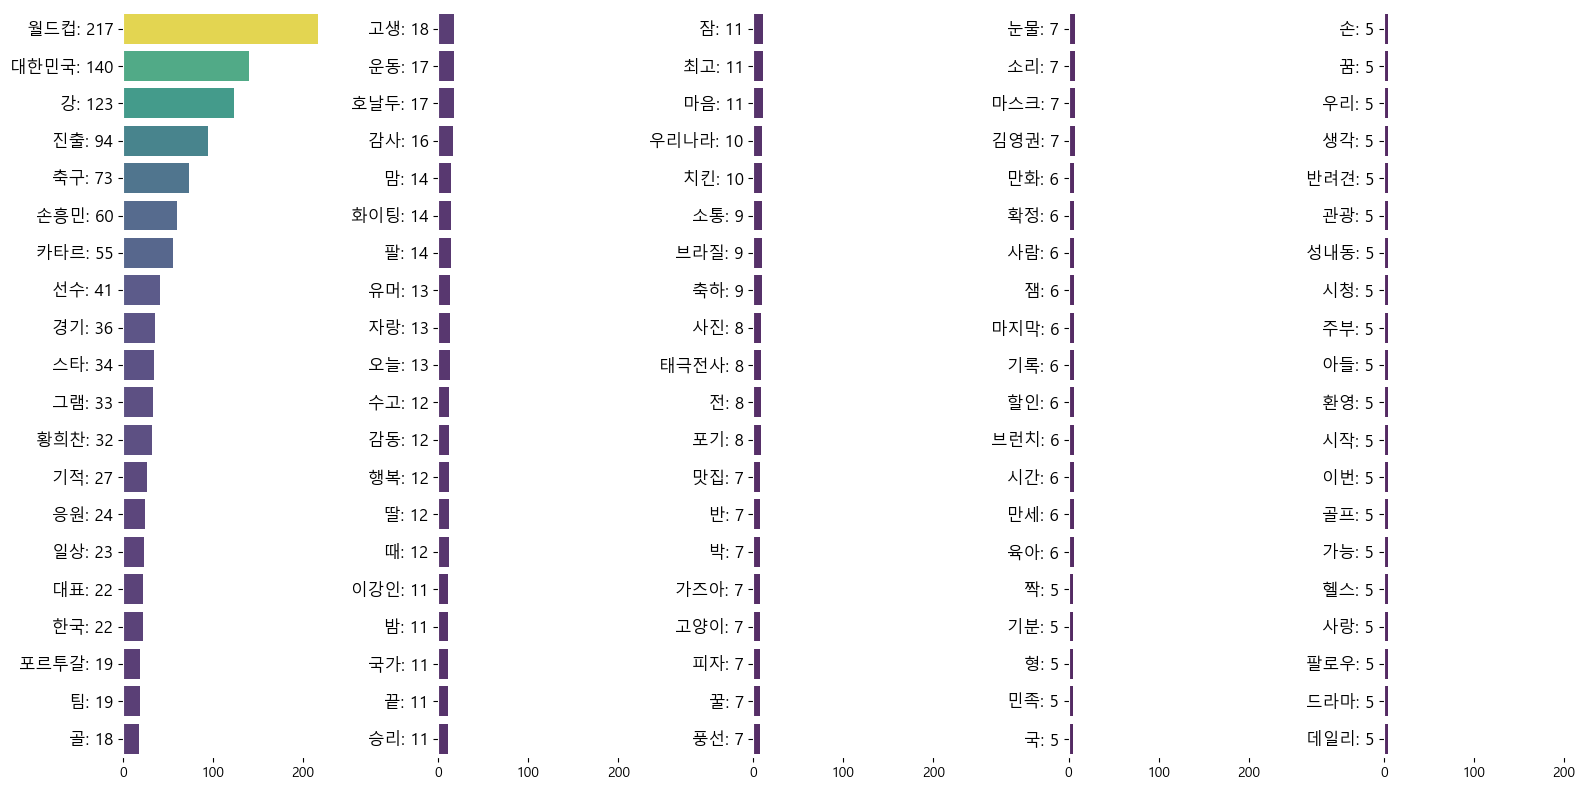

In [97]:
#create index list for slicing
index_list = [[i[0],i[-1]+1] for i in np.array_split(range(100), 5)]

n = df_words['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 5, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,5), index_list):
    df = df_words[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df['words'],df['count'])]
    color_l = [color_dict.get(i) for i in df['count']]
    x = list(df['count'])
    y = list(range(0,20))
    
    sns.barplot(x = x, y = y, data=df, alpha=0.9, orient = 'h',
                ax = axs[0][col], palette = color_l)
    axs[0][col].set_xlim(0,n+1)                     #set X axis range max
    axs[0][col].set_yticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.tight_layout() 
plt.show()

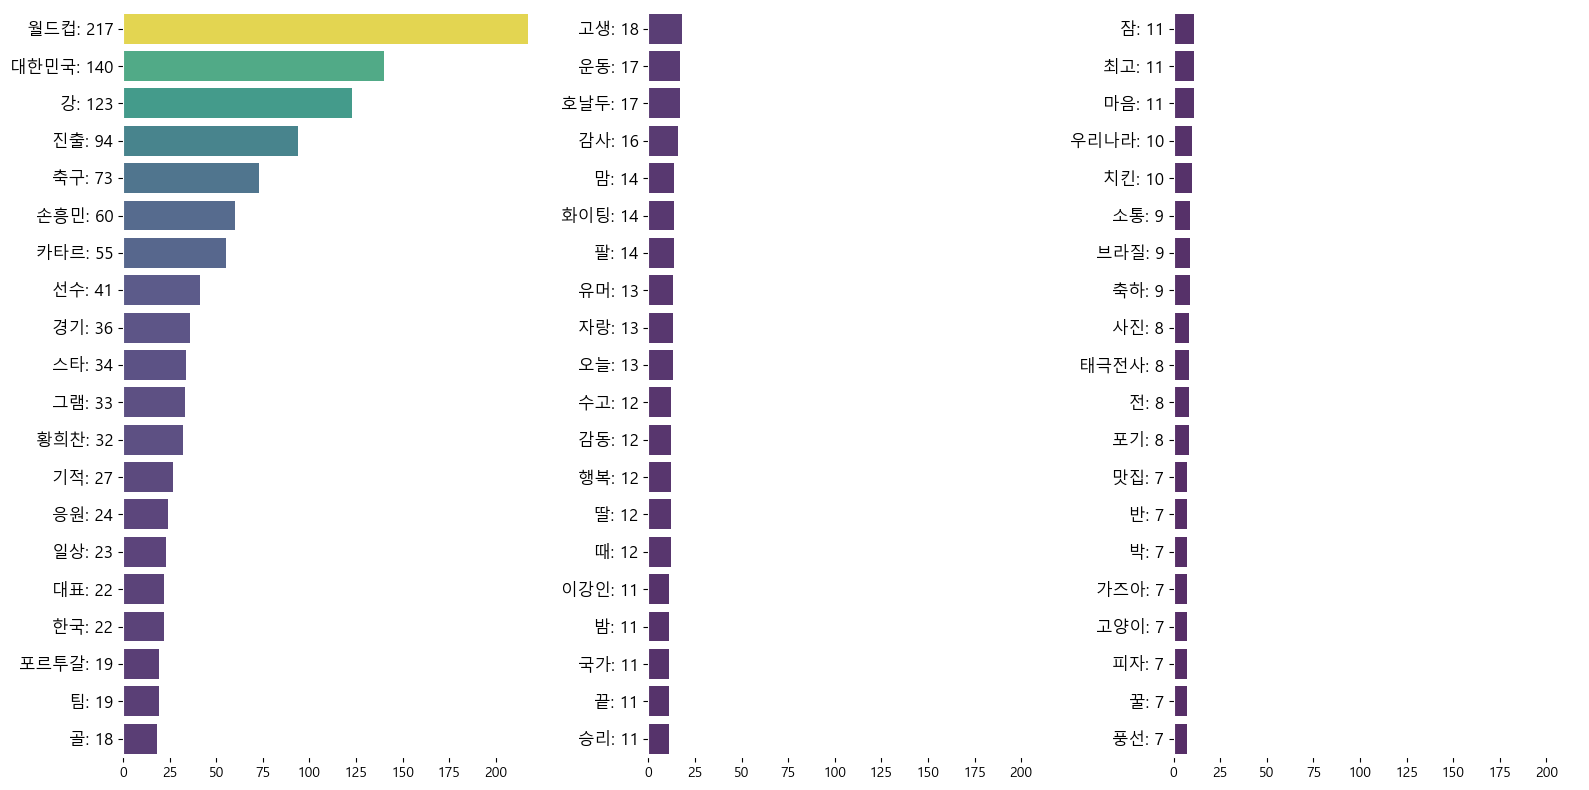

In [99]:
#create index list for slicing
index_list = [[i[0],i[-1]+1] for i in np.array_split(range(100), 5)]

n = df_words['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 3, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,3), index_list):
    df = df_words[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df['words'],df['count'])]
    color_l = [color_dict.get(i) for i in df['count']]
    x = list(df['count'])
    y = list(range(0,20))
    
    sns.barplot(x = x, y = y, data=df, alpha=0.9, orient = 'h',
                ax = axs[0][col], palette = color_l)
    axs[0][col].set_xlim(0,n+1)                     #set X axis range max
    axs[0][col].set_yticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.tight_layout() 
plt.show()

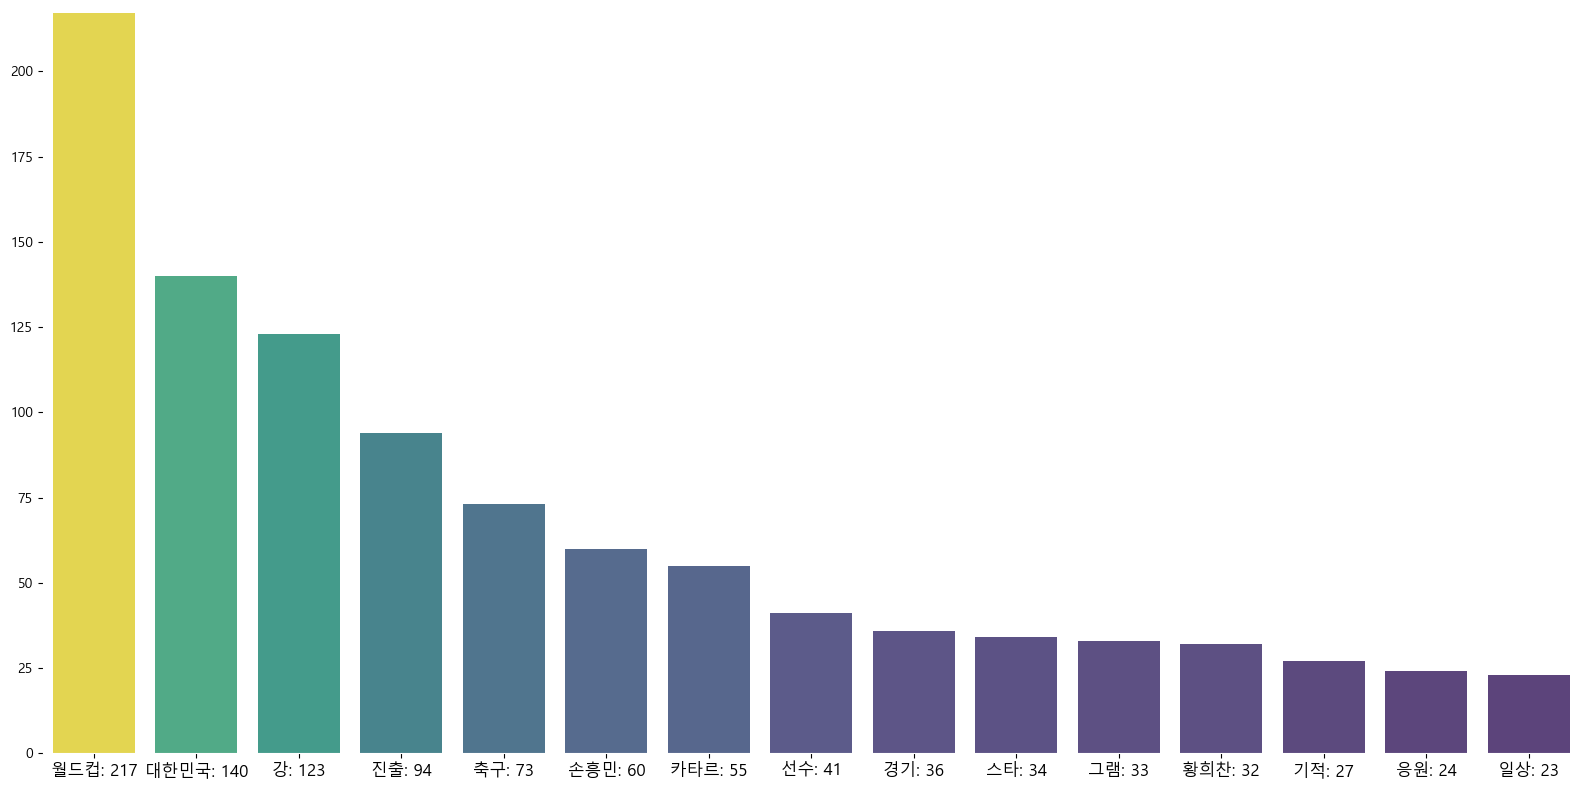

In [111]:
#create index list for slicing
index_list = [[i[0],i[-6]+1] for i in np.array_split(range(100), 5)]

n = df_words['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 1, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,1), index_list):
    df = df_words[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df['words'],df['count'])]
    color_l = [color_dict.get(i) for i in df['count']]
    y = list(df['count'])
    x = list(range(0,15))
    
    sns.barplot(x = x, y = y, data=df, alpha=0.9, orient = 'v',
                ax = axs[0][col], palette = color_l)
    axs[0][col].set_ylim(0,n+1)                     #set X axis range max
    axs[0][col].set_xticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.tight_layout() 
plt.show()

In [107]:
np.array_split(range(100), 5)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
        77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99])]

In [88]:
n = 30
pal = list(sns.color_palette(palette='Reds_r', n_colors=n).as_hex())

import plotly.express as px
fig = px.pie(df_words[0:20], values='count', names='words',
             color_discrete_sequence=pal)

fig.update_traces(textposition='outside', textinfo='percent+label', 
                  hole=.6, hoverinfo="label+percent+name")

fig.update_layout(width = 800, height = 600,
                  margin = dict(t=0, l=0, r=0, b=0))
fig.show()

In [50]:
!pip install plotly

     --------------------------------------- 15.3/15.3 MB 19.8 MB/s eta 0:00:00
